# Bike Sharing Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
boom_bike = pd.read_csv('data/day.csv')
boom_bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
boom_bike.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

## Preparing the data for modelling


```
Index([
 'instant',   - just row index - can drop
 'dteday',    - there are meaningful columns wrt to date - can drop
 'season',    - convert to dummy variable
 'yr',        - (0: 2018, 1:2019) - keep
 'mnth',      - month ( 1 to 12) - convert to dummy variable
 'holiday',   - not holiday(0) holiday (1)
 'weekday',   - (0-6) (Sun-Sat) - convert to dummy variable
 'workingday',- weekend nor holiday is 1, otherwise is 0
 'weathersit',- convert to dummy variable
 'temp',      - numberical variables
 'atemp',     - numberical variables
 'hum',       - numberical variables
 'windspeed', - numberical variables
 'casual',    - As the requirement is to find the driver variables related to the total users and these refer to a type of user, these can be dropped
 'registered',- As the requirement is to find the driver variables related to the total users and these refer to a type of user, these can be dropped
 'cnt'        - target variable
 ]
```

**Dropped fields**
- instant
- dteday
- casual
- registered


In [4]:
boom_bike = boom_bike.drop(columns=['instant','dteday','casual','registered'], axis=1)
boom_bike.info()
num_cols = ['cnt','temp','atemp','hum','windspeed']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


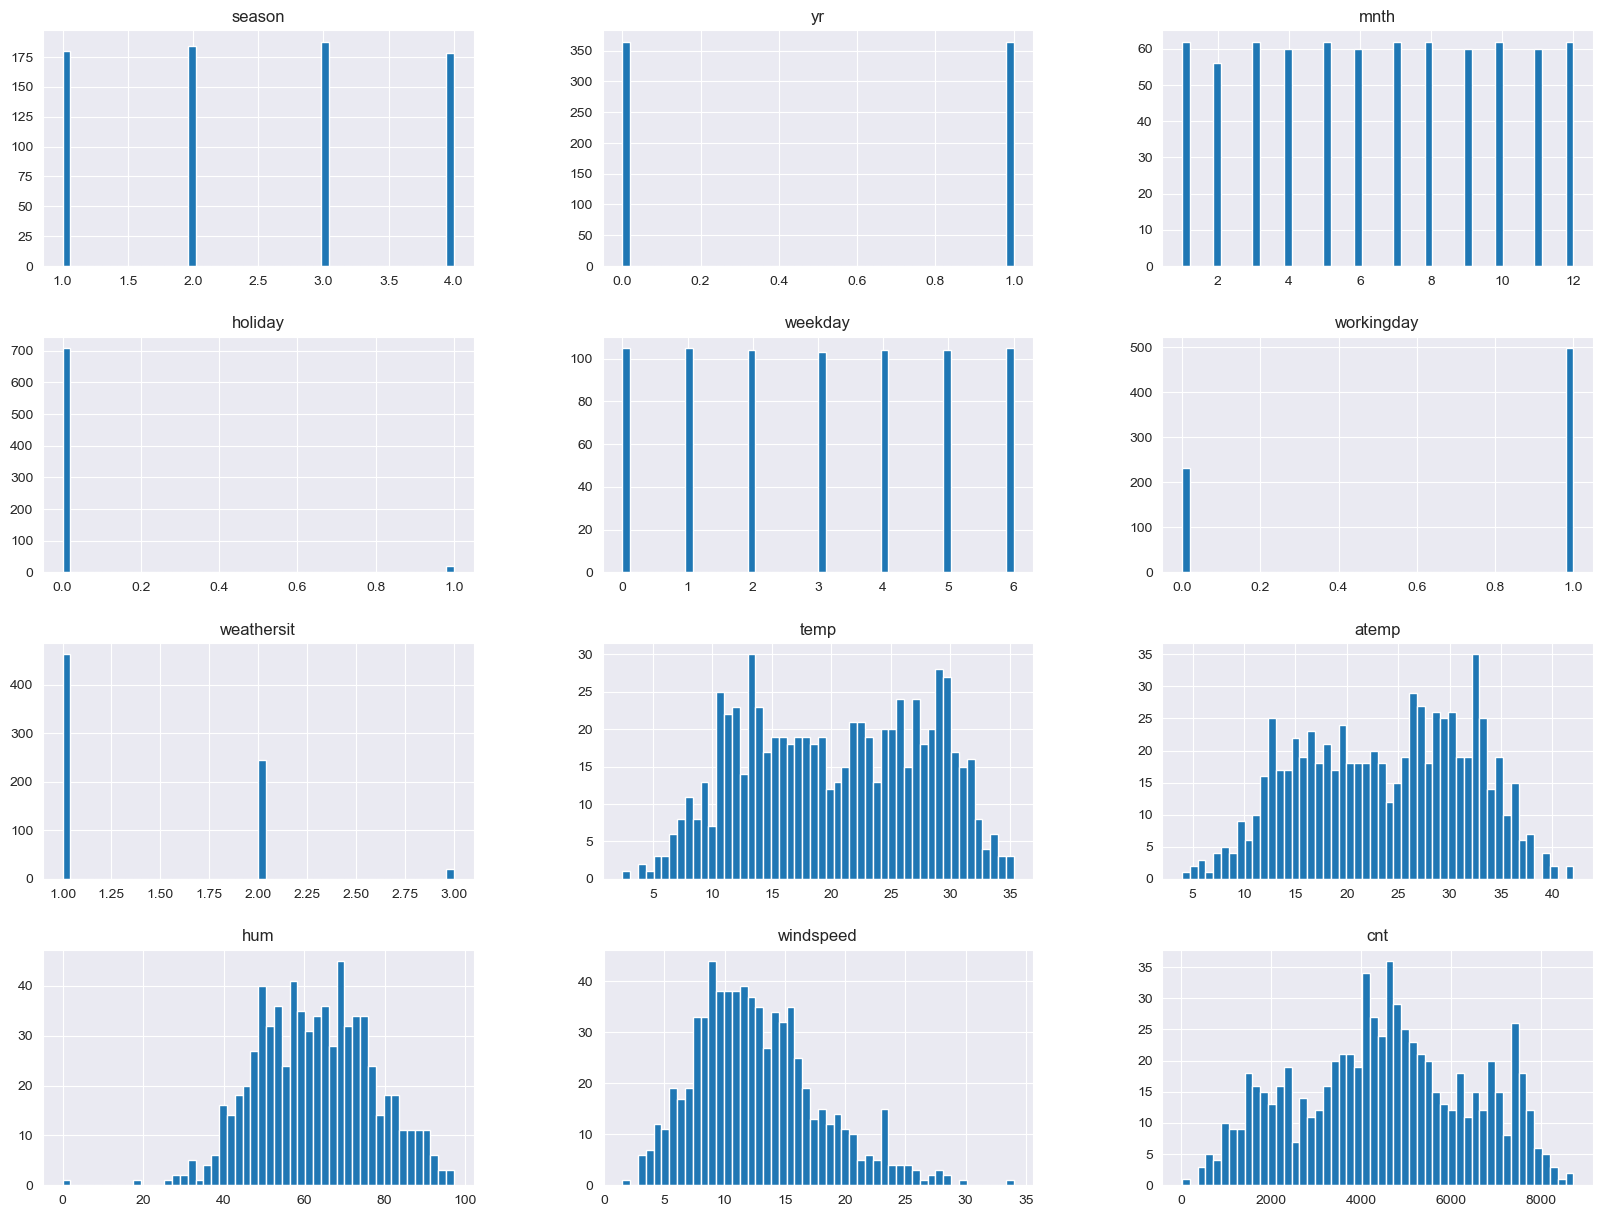

In [5]:
boom_bike.hist(bins=50, figsize=(20,15))
plt.show()


**Categorical Variables**
- season
- yr
- mnth
- holiday
- weekday
- workingday
- weathersit

**Numerical Variables**
- cnt
- temp
- atemp
- hum
- windspeed'

**Target Variable**
- cnt

In [6]:
boom_bike.isnull().sum()
# no empty values

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

## Visualization Numerical variables

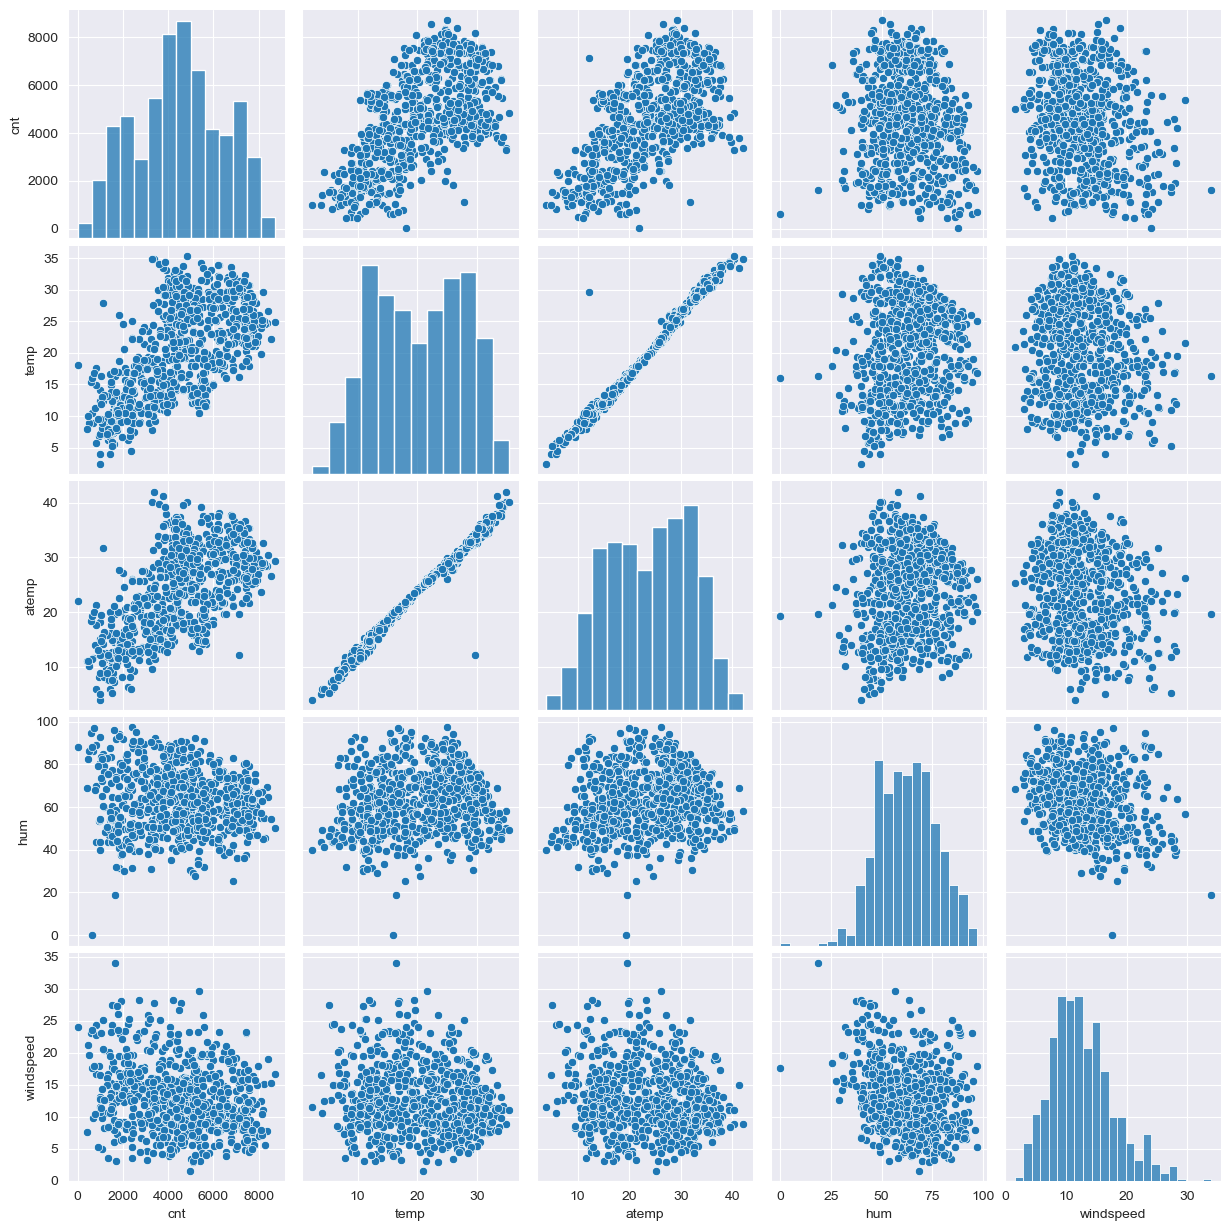

In [7]:
# Visualization Numerical variables towards to the target variable 'cnt'
sns.pairplot(boom_bike[num_cols])
plt.show()


Independent Variables that seem highly co-related to target variable **`cnt`**
 - registered
 - temp
 - atemp
 - casual

## Visualization Categorical variables

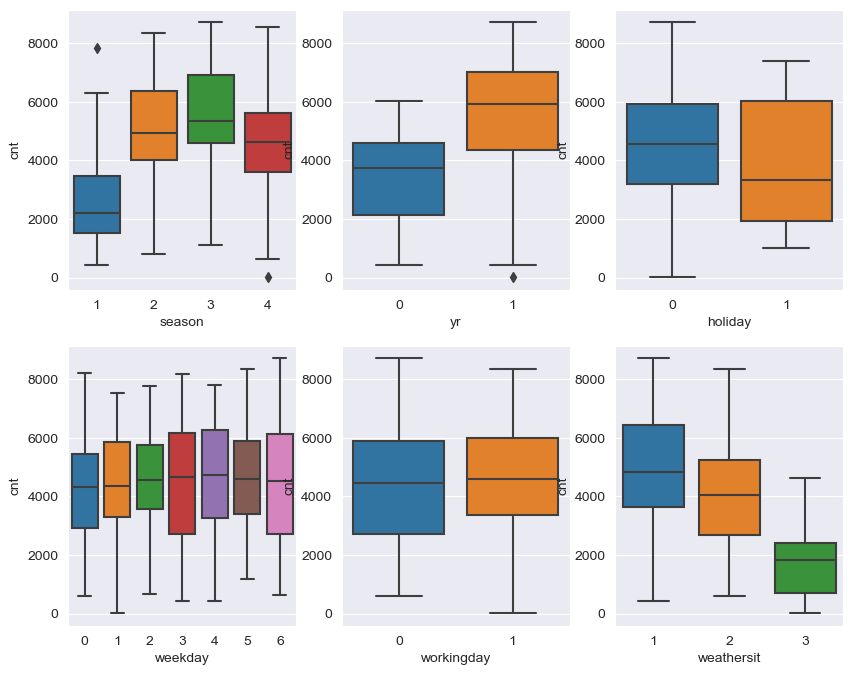

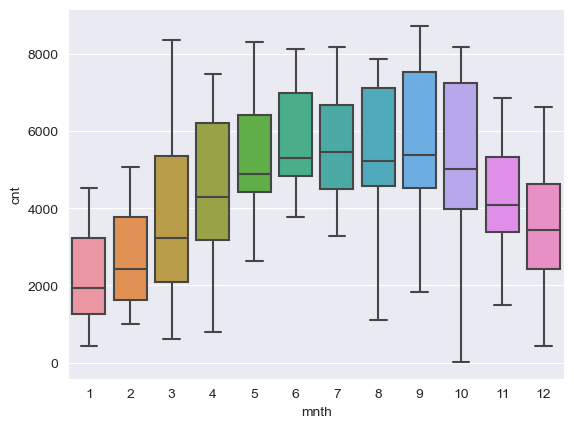

In [8]:
# Visualization Categorical variables towards to the target variable 'cnt'

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
sns.boxplot(x='season', y='cnt', data=boom_bike)
plt.subplot(2,3,2)
sns.boxplot(x='yr', y='cnt', data=boom_bike)
plt.subplot(2,3,3)
sns.boxplot(x='holiday', y='cnt', data=boom_bike)
plt.subplot(2,3,4)
sns.boxplot(x='weekday', y='cnt', data=boom_bike)
plt.subplot(2,3,5)
sns.boxplot(x='workingday', y='cnt', data=boom_bike)
plt.subplot(2,3,6)
sns.boxplot(x='weathersit', y='cnt', data=boom_bike)
plt.show()
sns.boxplot(x='mnth', y='cnt', data=boom_bike)
plt.show()



### Categorical Variables

 The qualitative distribution of bikes are mostly affected on the following categorical variables
-	**Season** – we see that the median increases from end of spring to summer indicating bikes are hired in driver climate
-	**Year** – 2019 has seen an considerable spike in usage of bikes
-	**Holiday** – There is wider distribution of bikes being hired when there is a holiday
-	**Weathersit** – There seems to be more bikes when the weather is good
-	**Month** – we see the median increase from May to June which might be indicative of the season

 The below two categorical variables doesn't show much deviation in the distribution of data
 - **weekday**
 - **working day**


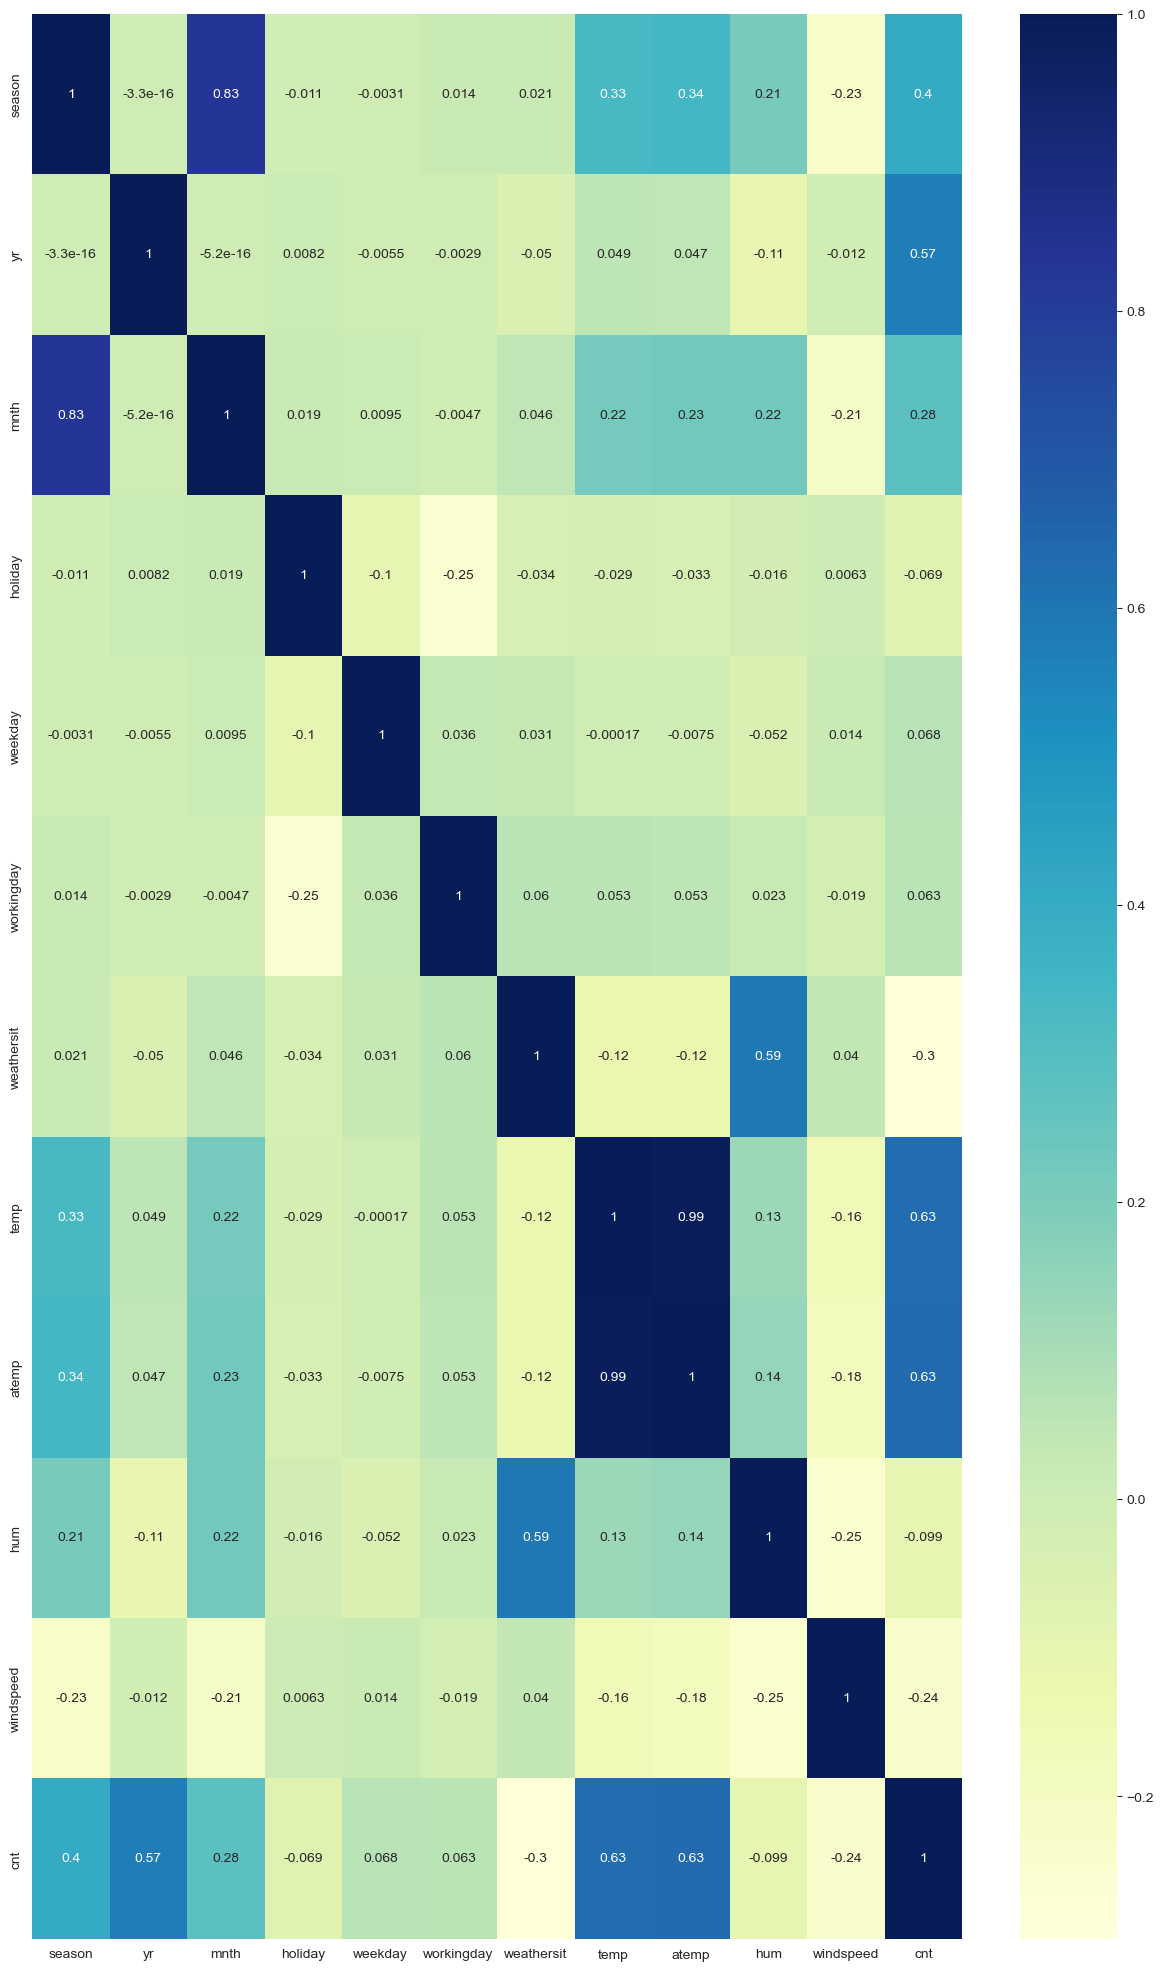

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
season,1.00,-0.00,0.83,-0.01,-0.00,0.01,0.02,0.33,0.34,0.21,-0.23,0.40
yr,-0.00,1.00,-0.00,0.01,-0.01,-0.00,-0.05,0.05,0.05,-0.11,-0.01,0.57
mnth,0.83,-0.00,1.00,0.02,0.01,-0.00,0.05,0.22,0.23,0.22,-0.21,0.28
holiday,-0.01,0.01,0.02,1.00,-0.10,-0.25,-0.03,-0.03,-0.03,-0.02,0.01,-0.07
weekday,-0.00,-0.01,0.01,-0.10,1.00,0.04,0.03,-0.00,-0.01,-0.05,0.01,0.07
workingday,0.01,-0.00,-0.00,-0.25,0.04,1.00,0.06,0.05,0.05,0.02,-0.02,0.06
weathersit,0.02,-0.05,0.05,-0.03,0.03,0.06,1.00,-0.12,-0.12,0.59,0.04,-0.30
temp,0.33,0.05,0.22,-0.03,-0.00,0.05,-0.12,1.00,0.99,0.13,-0.16,0.63
atemp,0.34,0.05,0.23,-0.03,-0.01,0.05,-0.12,0.99,1.00,0.14,-0.18,0.63
hum,0.21,-0.11,0.22,-0.02,-0.05,0.02,0.59,0.13,0.14,1.00,-0.25,-0.10


In [9]:
plt.figure(figsize=(15,25))
sns.heatmap(boom_bike.corr(),annot= True, cmap='YlGnBu')
plt.show()
boom_bike.corr().round(2)

Following independent variables have high co-relation
- season - mnt : 0.83
- temp - atemp : 0.99

Highest correlation to target variable -cnt
- temp - 0.63



In [10]:
boom_bike.drop('atemp',axis=1, inplace=True)
boom_bike.drop('mnth',axis=1, inplace=True)


# Multilinear-regression

In [11]:
boom_bike.head()

,season,yr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,0,0,0,2,14.902598,69.6087,16.652113,801
2,1,0,0,1,1,1,8.050924,43.7273,16.636703,1349
3,1,0,0,2,1,1,8.200000,59.0435,10.739832,1562
4,1,0,0,3,1,1,9.305237,43.6957,12.522300,1600


## Convert Categorical Variables

In [12]:
def apply_weekday(weekday):
    if weekday == 0:
        return "Sunday"
    elif weekday == 1:
        return "Monday"
    elif weekday == 2:
        return "Tuesday"
    elif weekday == 3:
        return "Wednesday"
    elif weekday == 4:
        return "Thursday"
    elif weekday == 5:
        return "Friday"
    else:
        return "Saturday"


boom_bike['weekday'] = boom_bike.weekday.apply(apply_weekday)
weekday = pd.get_dummies(boom_bike.weekday, drop_first=True)
boom_bike = pd.concat([boom_bike, weekday], axis=1)
boom_bike.drop('weekday', axis=1, inplace=True)

# Create dummy variables for Season
def apply_season(season):
    if season == 1:
        return 'spring'
    elif season == 2:
        return 'summer'
    elif season == 3:
        return 'fall'
    else:
        return 'winter'

boom_bike['season'] = boom_bike.season.apply(apply_season)
season = pd.get_dummies(boom_bike.season, drop_first=True)
boom_bike = pd.concat([boom_bike, season], axis=1)
boom_bike.drop('season', axis=1, inplace=True)


# Create dummy variables for Weathersit

def apply_weathersit(weather):
    if weather == 1:
        return "Good Weather"
    elif weather == 2:
        return "OK Weather"
    elif weather == 3:
        return "Mild Weather"
    else:
        return "Bad Weather"

boom_bike['weathersit'] = boom_bike.weathersit.apply(apply_weathersit)
# Looks like there is no entry for Bad weather ie weathersit=4
# we can consider the data set for only 3 levels and assume Bad Weather isn't encoded
weathersit = pd.get_dummies(boom_bike.weathersit, drop_first=True)
boom_bike = pd.concat([boom_bike, weathersit], axis=1)
boom_bike.drop('weathersit', axis=1, inplace=True)

boom_bike.head()



,yr,holiday,workingday,temp,hum,windspeed,cnt,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,winter,Mild Weather,OK Weather
0,0,0,0,14.110847,80.5833,10.749882,985,0,1,0,0,0,0,1,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,1,0,0,0,1,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,0,1,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,0,0,1,1,0,0,0,0


In [13]:
boom_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            730 non-null    int64  
 1   holiday       730 non-null    int64  
 2   workingday    730 non-null    int64  
 3   temp          730 non-null    float64
 4   hum           730 non-null    float64
 5   windspeed     730 non-null    float64
 6   cnt           730 non-null    int64  
 7   Monday        730 non-null    uint8  
 8   Saturday      730 non-null    uint8  
 9   Sunday        730 non-null    uint8  
 10  Thursday      730 non-null    uint8  
 11  Tuesday       730 non-null    uint8  
 12  Wednesday     730 non-null    uint8  
 13  spring        730 non-null    uint8  
 14  summer        730 non-null    uint8  
 15  winter        730 non-null    uint8  
 16  Mild Weather  730 non-null    uint8  
 17  OK Weather    730 non-null    uint8  
dtypes: float64(3), int64(4), uint8

In [14]:
df_train, df_test = train_test_split(boom_bike, train_size=0.7, random_state=100)

print(df_train.shape)
print(df_test.shape)

#scaling
scaler = MinMaxScaler()
num_vars = ['temp','hum','windspeed','cnt']
#Fit on data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()


(510, 18)
(220, 18)


,yr,holiday,workingday,temp,hum,windspeed,cnt,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,winter,Mild Weather,OK Weather
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,0,1,0,0,0,0,1,0,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0.204096,0,0,1,0,0,0,1,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,1,0,0,1
111,0,0,1,0.345824,0.751824,0.380981,0.191095,0,0,0,0,0,0,0,1,0,0,1


In [15]:
y_train = df_train.pop('cnt')
X_train = df_train

print( X_train.shape)
print( y_train.shape)

(510, 17)
(510,)


In [16]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))


[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Monday', False, 5),
 ('Saturday', True, 1),
 ('Sunday', True, 1),
 ('Thursday', False, 7),
 ('Tuesday', False, 6),
 ('Wednesday', False, 8),
 ('spring', True, 1),
 ('summer', False, 4),
 ('winter', False, 3),
 ('Mild Weather', True, 1),
 ('OK Weather', False, 2)]

In [17]:
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     239.2
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          7.11e-175
Time:                        22:49:24   Log-Likelihood:                 464.41
No. Observations:                 510   AIC:                            -908.8
Df Residuals:                     500   BIC:                            -866.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3293      0.024     13.474   

In [18]:
# High p-value for holiday 0.174 - so drop from model
X_train_rfe_new = X_train_rfe.drop(['holiday'], axis=1)
X_train_lm = sm.add_constant(X_train_rfe_new)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())
# Multi colinearity
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_new.values, i) for i in range(X_train_rfe_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     239.2
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          7.11e-175
Time:                        22:49:24   Log-Likelihood:                 464.41
No. Observations:                 510   AIC:                            -908.8
Df Residuals:                     500   BIC:                            -866.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3603      0.040      9.043   

,Features,VIF
0,const,83.78
2,workingday,8.97
6,Saturday,6.00
7,Sunday,5.69
3,temp,1.63
8,spring,1.62
4,hum,1.21
5,windspeed,1.13
9,Mild Weather,1.10
1,yr,1.03


In [19]:
# High p-value for Sunday 0.183 - so drop from model
X_train_rfe_new = X_train_rfe_new.drop(['Sunday'], axis=1)
X_train_lm = sm.add_constant(X_train_rfe_new)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())
# Multi colinearity
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_new.values, i) for i in range(X_train_rfe_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     268.4
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          1.02e-175
Time:                        22:49:24   Log-Likelihood:                 463.50
No. Observations:                 510   AIC:                            -909.0
Df Residuals:                     501   BIC:                            -870.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3928      0.032     12.467   

,Features,VIF
0,const,52.32
2,workingday,1.63
3,temp,1.63
6,Saturday,1.63
7,spring,1.62
4,hum,1.21
5,windspeed,1.13
8,Mild Weather,1.10
1,yr,1.03


## Residual Analysis

<Figure size 640x480 with 0 Axes>

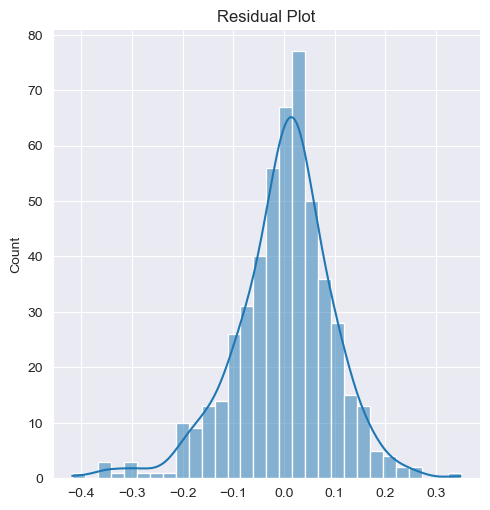

In [20]:
#error = f(y_train, y_train_pred)
y_train_pred = lm.predict(X_train_lm)
y_train_pred
residuals = y_train - y_train_pred
plt.figure()
sns.displot(residuals, kde=True)
plt.title("Residual Plot")
plt.show()


## MODEL EVALUATION


In [21]:
# scale the test data
df_test[num_vars] = scaler.transform(df_test[num_vars])
y_test = df_test.pop('cnt')
X_test = df_test
X_test_sm = sm.add_constant(X_test)
print(X_test_sm.shape)
print(X_train_lm.shape)
X_train_lm.columns


(220, 18)
(510, 9)


Index(['const', 'yr', 'workingday', 'temp', 'hum', 'windspeed', 'Saturday',
       'spring', 'Mild Weather'],
      dtype='object')

<Figure size 640x480 with 0 Axes>

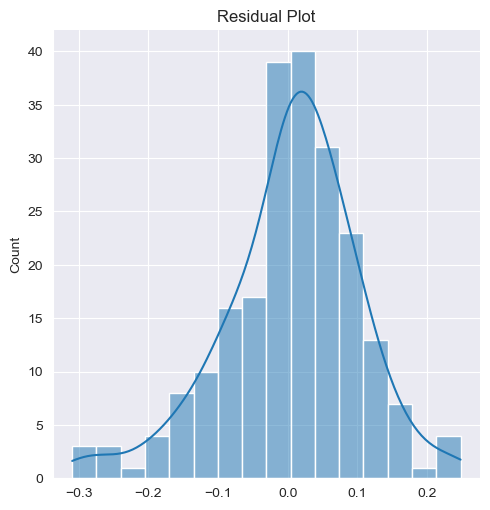

In [22]:
y_test_pred = lm.predict(X_test_sm[X_train_lm.columns])
residuals = y_test - y_test_pred
plt.figure()
sns.displot(residuals, kde=True)
plt.title("Residual Plot")
plt.show()



## R^2 Value for TEST

In [23]:
# Evaluate the model
print(r2_score(y_true=y_test,y_pred=y_test_pred))
print(r2_score(y_true=y_train, y_pred=y_train_pred))


0.8005000364100178
0.8108312521753585


## Test Score
> Test data vs. Training data => 0.80 to 0.81

### Features selected in the model
- workingday
- temp
- Saturday
- spring
- hum
- windspeed
- Mild Weather
- yr

The above features best describe the count the of


In [24]:
print (boom_bike[boom_bike.yr == 0].temp.mean())
print (boom_bike[boom_bike.yr == 1].temp.mean())

print (boom_bike[(boom_bike.yr == 0) & (boom_bike.workingday == 0)].workingday.count())
print (boom_bike[(boom_bike.yr == 1) & (boom_bike.workingday == 0)].workingday.count())

print (boom_bike[(boom_bike.yr == 0) & (boom_bike.Saturday == 1)].Saturday.count())
print (boom_bike[(boom_bike.yr == 1) & (boom_bike.Saturday == 1)].Saturday.count())


print (boom_bike[(boom_bike.yr == 0) & (boom_bike.spring == 1)].spring.count())
print (boom_bike[(boom_bike.yr == 1) & (boom_bike.spring == 1)].spring.count())

print (boom_bike[boom_bike.yr == 0].hum.mean())
print (boom_bike[boom_bike.yr == 1].hum.mean())

print (boom_bike[boom_bike.yr == 0].windspeed.mean())
print (boom_bike[boom_bike.yr == 1].windspeed.mean())

print (boom_bike[(boom_bike.yr == 0) & (boom_bike['Mild Weather'] == 1)]['Mild Weather'].count())
print (boom_bike[(boom_bike.yr == 1) & (boom_bike['Mild Weather'] == 1)]['Mild Weather'].count())


19.95326291068493
20.685255523287676
115
116
53
52
90
90
64.36647671232875
61.16387315068498
12.823976531232866
12.70326277808219
15
6


# Conclusions
- Following features best fit the model
  - workingday
  - temp
  - Saturday
  - spring
  - hum
  - windspeed
  - Mild Weather
  - yr
- This model gives an r-squared score  `0.80 - 0.81` w.r.t test data - training data
- There is a positive correlation for the following features
  - temp (19.9 -> 20.68 average)
  - workingday (115 -> 116)
  - Saturday (53 -> 52)
  - We see the variables increased from 2018 and 2019
- There is a negative correlation for the following features
  - spring (90 -> 90)
  - hum (64.36 -> 61.16)
  - windspeed (12.8 -> 12.7)
  - Mild Weather (15 -> 6)
  - We also see the variables decreased / same from 2018 and 2019

These could also explain why there has been an increase in bikes used in 2019

It looks like favourable climate or environment is the main driving factor for using bikes

There might be people using bikes for their daily work as `workingday` is one of the features with a positive correlation and an equal amount of people using it on `Saturday` for leisure

So business should look to see if people working from home is one of the factors in reducing sales
